<a href="https://colab.research.google.com/github/c4bath/cf860/blob/main/APTOS_EfficientNetV2B3_CLAHE_d5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File Details

Dataset: APTOS w CLAHE preprocessing

Model: EfficientNetV2B3

Adapted from

Transfer learning and fine-tuning

https://www.tensorflow.org/tutorials/images/transfer_learning

coursera - Retinopathy Detection Using Deep Learning

 https://www.coursera.org/learn/retinopathy-detection-using-deep-learning/supplement/em4yb/project-based-course-overview



# Results - Summary

EfficientNetV2B3

**Initial Training 10 Epochs**

The epoch with the lowest loss is: 8 (Loss: 1.2695)

The epoch with the lowest val_loss is: 10 (Val Loss: 1.3017)

The epoch with the highest accuracy is: 2 (Accuracy: 1.285)

The epoch with the highest validation accuracy is: 1 (Val Accuracy: 1.3278)

The epoch with the highest MCC is: 10 (MCC: 0.0349)

The epoch with the highest validation MCC is: 10 (Val MCC: 0.046)



**Fine Tuning 45 Epochs**

The epoch with the lowest loss is: 40 (Loss: 0.8823)

The epoch with the lowest val_loss is: 43 (Val Loss: 0.8892)

The epoch with the highest accuracy is: 1 (Accuracy: 1.2656)

The epoch with the highest validation accuracy is: 1 (Val Accuracy: 1.2888)

The epoch with the highest MCC is: 46 (MCC: 0.4986)

The epoch with the highest validation MCC is: 35 (Val MCC: 0.5063)



**Testing APTOS (Primary)**

Test accuracy : 0.8152027726173401

Test MCC : 0.5170127749443054

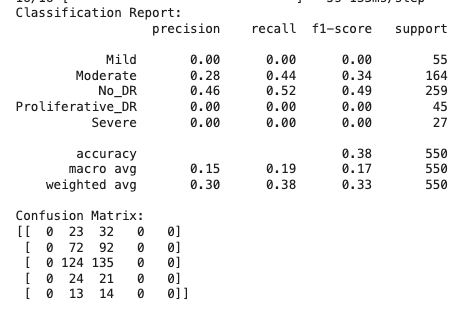


**Testing Kaggle Eypacs (Secondary)**

Test accuracy : 3.1564080715179443

Test MCC : 0.021782182157039642

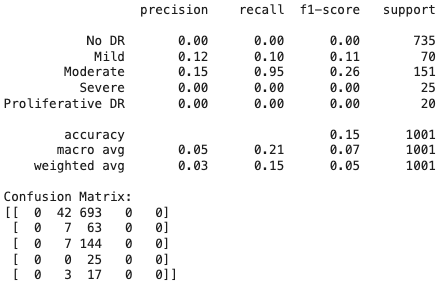






In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
import seaborn as sns
import plotly
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix,cohen_kappa_score, matthews_corrcoef
from plotly.offline import iplot, init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  6 01:18:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
os.listdir('/content/drive/MyDrive/train')

['Mild', 'Moderate', 'No_DR', 'Proliferative_DR', 'Severe']

In [6]:
# To have reproducible results
seed = 27

np.random.seed(seed)

tf.random.set_seed(seed)

num_classes = 5

IMG_SIZE = (224,224)

In [7]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('/content/drive/MyDrive/train'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/train', i))
  for j in train_class:
    img = os.path.join('train', i, j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))
print('Number of train labels : {} \n'.format(len(label)))

Number of train images : 3662 

Number of train labels : 3662 



In [8]:
No_images_per_class = []
Class_name = []
for i in os.listdir('/content/drive/MyDrive/train'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Mild = 370 

Number of images in Moderate = 999 

Number of images in No_DR = 1805 

Number of images in Proliferative_DR = 295 

Number of images in Severe = 193 



In [9]:
retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df

,Image,Labels
0,train/Mild/677f087cd697.png,Mild
1,train/Mild/ea15a290eb96.png,Mild
2,train/Mild/07929d32b5b3.png,Mild
3,train/Mild/35d6c4c50072.png,Mild
4,train/Mild/a5a2a7003d60.png,Mild
...,...,...
3657,train/Severe/bb7e0a2544cd.png,Severe
3658,train/Severe/38055d8b9f08.png,Severe
3659,train/Severe/36b5b3c9fb32.png,Severe
3660,train/Severe/51269b77d312.png,Severe


In [10]:
# Shuffle the data and split it into training, testing and validation
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.3)
val, test = train_test_split(test, test_size = 0.5)

In [11]:
train_datagen =  ImageDataGenerator(
    zoom_range=0.15,  # set range for random zoom, changed from 0.15 to 0.3, now changed from 0.3 to 0.45, from 0.45 to 0.6
    fill_mode='constant',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,# randomly flip images
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255)


# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
base_path = '/content/drive/My Drive/'  # Your base path

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

validation_generator = val_datagen.flow_from_dataframe(
    val,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)


Found 2563 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [13]:
images, labels = next(test_generator)

In [14]:
example_image = images[0]


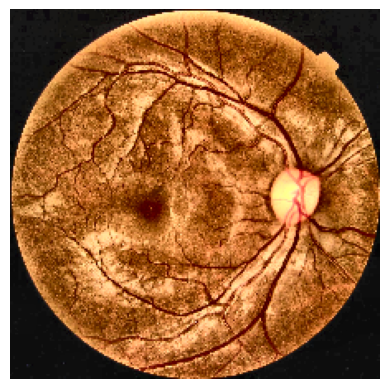

In [15]:
plt.imshow(example_image)
plt.axis('off')  # To turn off the axis
plt.show()

In [16]:
# Matthews Correlation Coefficient for multiple classes

class MatthewsCorrelationCoefficient(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="matthews_correlation_coefficient", **kwargs):
        super(MatthewsCorrelationCoefficient, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.confusion_matrix = self.add_weight(
            name="confusion_matrix",
            shape=(num_classes, num_classes),
            initializer="zeros"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)

        new_confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, self.num_classes)
        new_confusion_matrix = tf.cast(new_confusion_matrix, self.confusion_matrix.dtype)

        return self.confusion_matrix.assign_add(new_confusion_matrix)

    def result(self):
        sum_over_row = tf.reduce_sum(self.confusion_matrix, axis=0)
        sum_over_col = tf.reduce_sum(self.confusion_matrix, axis=1)
        true_positives = tf.linalg.diag_part(self.confusion_matrix)
        predicted_positives = sum_over_row
        actual_positives = sum_over_col
        total_samples = tf.reduce_sum(sum_over_row)

        mcc_numerator = tf.reduce_sum(true_positives * total_samples - predicted_positives * actual_positives)
        mcc_denominator = tf.sqrt(
            (total_samples**2 - tf.reduce_sum(predicted_positives**2)) *
            (total_samples**2 - tf.reduce_sum(actual_positives**2))
        )

        mcc = mcc_numerator / mcc_denominator
        mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
        return mcc

    def reset_state(self):
        for s in self.variables:
            s.assign(tf.zeros_like(s))

    def get_config(self):
        config = super(MatthewsCorrelationCoefficient, self).get_config()
        config.update({"num_classes": self.num_classes})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

mcc_metric = MatthewsCorrelationCoefficient(num_classes)

In [17]:
base_model = tf.keras.applications.EfficientNetV2B3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

52606240/52606240 [==============================] - 0s 0us/step


In [18]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1536)


In [19]:
base_model.trainable = False

In [20]:
# Display Model
base_model.summary()

Model: "efficientnetv2-b3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 40)         1080      ['normalizatio

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [22]:
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs) already augmented in train_generator
#x = preprocess_input(x) already rescaled in train and val_generator
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 12938307 (49.36 MB)
Trainable params: 7685 (30.

In [25]:
len(model.trainable_variables)

2

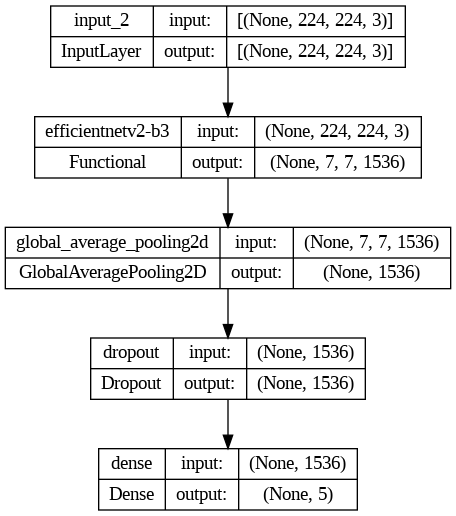

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalCrossentropy(name='accuracy'),mcc_metric])

In [28]:
#apply early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#save the best model with lowest validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/drweights/EffNetweightsd5b.hdf5", verbose=1, save_best_only=True)


In [29]:
initial_epochs = 10

In [30]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = initial_epochs, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/10
80/80 [==============================] - ETA: 0s - loss: 1.3783 - accuracy: 1.3783 - matthews_correlation_coefficient: -0.0102 
Epoch 1: val_loss improved from inf to 1.32949, saving model to /content/drive/MyDrive/drweights/EffNetweightsd5b.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



80/80 [==============================] - 1159s 14s/step - loss: 1.3783 - accuracy: 1.3783 - matthews_correlation_coefficient: -0.0102 - val_loss: 1.3295 - val_accuracy: 1.3295 - val_matthews_correlation_coefficient: 0.0000e+00
Epoch 2/10
80/80 [==============================] - ETA: 0s - loss: 1.2861 - accuracy: 1.2861 - matthews_correlation_coefficient: 0.0040
Epoch 2: val_loss did not improve from 1.32949
80/80 [==============================] - 46s 579ms/step - loss: 1.2861 - accuracy: 1.2861 - matthews_correlation_coefficient: 0.0040 - val_loss: 1.3303 - val_accuracy: 1.3303 - val_matthews_correlation_coefficient: 0.0000e+00
Epoch 3/10
80/80 [==============================] - ETA: 0s - loss: 1.2896 - accuracy: 1.2896 - matthews_correlation_coefficient: 0.0000e+00
Epoch 3: val_loss improved from 1.32949 to 1.32233, saving model to /content/drive/MyDrive/drweights/EffNetweightsd5b.hdf5
80/80 [==============================] - 45s 557ms/step - loss: 1.2896 - accuracy: 1.2896 - matthew

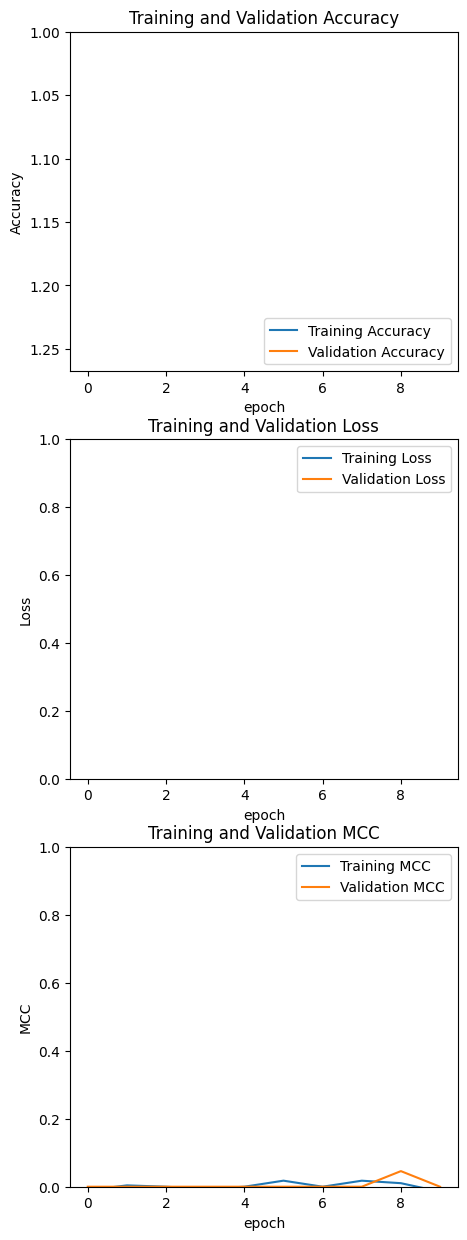

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

matthews_correlation_coefficient = history.history['matthews_correlation_coefficient']
val_matthews_correlation_coefficient = history.history['val_matthews_correlation_coefficient']

fig, axs = plt.subplots(3, 1, figsize=(5, 15))

plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')


plt.subplot(3, 1, 3)
plt.plot(matthews_correlation_coefficient, label='Training MCC')
plt.plot(val_matthews_correlation_coefficient, label='Validation MCC')
plt.legend(loc='upper right')
plt.ylabel('MCC')
plt.ylim([0,1.0])
plt.title('Training and Validation MCC')
plt.xlabel('epoch')
plt.show()

In [32]:
# Loss
min_loss_index = np.argmin(history.history['loss'])
min_loss_value = round(history.history['loss'][min_loss_index], 4)
print(f'The epoch with the lowest loss is: {min_loss_index + 1} (Loss: {min_loss_value})')

# Validation Loss
min_val_loss_index = np.argmin(history.history['val_loss'])
min_val_loss_value = round(history.history['val_loss'][min_val_loss_index], 4)
print(f'The epoch with the lowest val_loss is: {min_val_loss_index + 1} (Val Loss: {min_val_loss_value})')

# Accuracy
max_accuracy_index = np.argmax(history.history['accuracy'])
max_accuracy_value = round(history.history['accuracy'][max_accuracy_index], 4)
print(f'The epoch with the highest accuracy is: {max_accuracy_index + 1} (Accuracy: {max_accuracy_value})')

# Validation Accuracy
max_val_acc_index = np.argmax(history.history['val_accuracy'])
max_val_acc_value = round(history.history['val_accuracy'][max_val_acc_index], 4)
print(f'The epoch with the highest validation accuracy is: {max_val_acc_index + 1} (Val Accuracy: {max_val_acc_value})')

# Matthews Correlation Coefficient (MCC)
max_mcc_index = np.argmax(history.history['matthews_correlation_coefficient'])
max_mcc_value = round(history.history['matthews_correlation_coefficient'][max_mcc_index], 4)
print(f'The epoch with the highest MCC is: {max_mcc_index + 1} (MCC: {max_mcc_value})')

# Validation MCC
max_val_mcc_index = np.argmax(history.history['val_matthews_correlation_coefficient'])
max_val_mcc_value = round(history.history['val_matthews_correlation_coefficient'][max_val_mcc_index], 4)
print(f'The epoch with the highest validation MCC is: {max_val_mcc_index + 1} (Val MCC: {max_val_mcc_value})')

best_epoch_model = max_val_mcc_index + 1

The epoch with the lowest loss is: 9 (Loss: 1.273)
The epoch with the lowest val_loss is: 10 (Val Loss: 1.3072)
The epoch with the highest accuracy is: 1 (Accuracy: 1.3783)
The epoch with the highest validation accuracy is: 2 (Val Accuracy: 1.3303)
The epoch with the highest MCC is: 6 (MCC: 0.0178)
The epoch with the highest validation MCC is: 9 (Val MCC: 0.0459)


In [33]:
base_model.trainable = True

In [34]:
# Total layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  409


In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalCrossentropy(name='accuracy'),mcc_metric])

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 12938307 (49.36 MB)
Trainable params: 11992821 

In [37]:
len(model.trainable_variables)

272

In [38]:
fine_tune_epochs = 45
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = total_epochs, initial_epoch=history.epoch[-1], validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 10/55
80/80 [==============================] - ETA: 0s - loss: 1.2677 - accuracy: 1.2677 - matthews_correlation_coefficient: 0.0570
Epoch 10: val_loss improved from 1.30716 to 1.27702, saving model to /content/drive/MyDrive/drweights/EffNetweightsd5b.hdf5
80/80 [==============================] - 103s 664ms/step - loss: 1.2677 - accuracy: 1.2677 - matthews_correlation_coefficient: 0.0570 - val_loss: 1.2770 - val_accuracy: 1.2770 - val_matthews_correlation_coefficient: 0.1142
Epoch 11/55
80/80 [==============================] - ETA: 0s - loss: 1.2230 - accuracy: 1.2230 - matthews_correlation_coefficient: 0.1514
Epoch 11: val_loss improved from 1.27702 to 1.21019, saving model to /content/drive/MyDrive/drweights/EffNetweightsd5b.hdf5
80/80 [==============================] - 54s 669ms/step - loss: 1.2230 - accuracy: 1.2230 - matthews_correlation_coefficient: 0.1514 - val_loss: 1.2102 - val_accuracy: 1.2102 - val_matthews_correlation_coefficient: 0.2882
Epoch 12/55
80/80 [============

In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

matthews_correlation_coefficient += history_fine.history['matthews_correlation_coefficient']
val_matthews_correlation_coefficient += history_fine.history['val_matthews_correlation_coefficient']

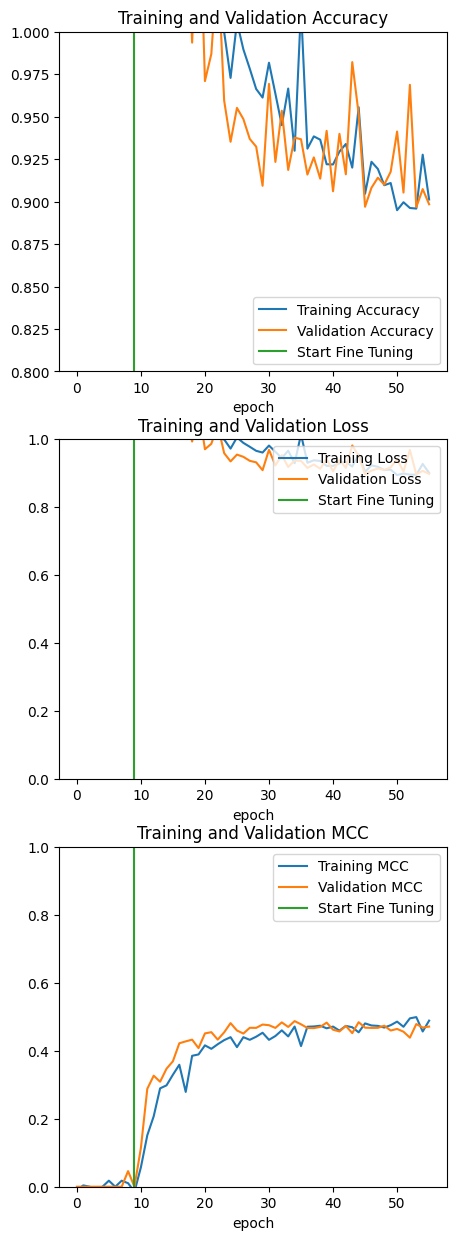

In [40]:
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(matthews_correlation_coefficient, label='Training MCC')
plt.plot(val_matthews_correlation_coefficient, label='Validation MCC')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation MCC')
plt.xlabel('epoch')

plt.show()

In [41]:
# Loss
min_loss_index = np.argmin(history_fine.history['loss'])
min_loss_value = round(history_fine.history['loss'][min_loss_index], 4)
print(f'The epoch with the lowest loss is: {min_loss_index + 1} (Loss: {min_loss_value})')

# Validation Loss
min_val_loss_index = np.argmin(history_fine.history['val_loss'])
min_val_loss_value = round(history_fine.history['val_loss'][min_val_loss_index], 4)
print(f'The epoch with the lowest val_loss is: {min_val_loss_index + 1} (Val Loss: {min_val_loss_value})')

# Accuracy
max_accuracy_index = np.argmax(history_fine.history['accuracy'])
max_accuracy_value = round(history_fine.history['accuracy'][max_accuracy_index], 4)
print(f'The epoch with the highest accuracy is: {max_accuracy_index + 1} (Accuracy: {max_accuracy_value})')

# Validation Accuracy
max_val_acc_index = np.argmax(history_fine.history['val_accuracy'])
max_val_acc_value = round(history_fine.history['val_accuracy'][max_val_acc_index], 4)
print(f'The epoch with the highest validation accuracy is: {max_val_acc_index + 1} (Val Accuracy: {max_val_acc_value})')

# Matthews Correlation Coefficient (MCC)
max_mcc_index = np.argmax(history_fine.history['matthews_correlation_coefficient'])
max_mcc_value = round(history_fine.history['matthews_correlation_coefficient'][max_mcc_index], 4)
print(f'The epoch with the highest MCC is: {max_mcc_index + 1} (MCC: {max_mcc_value})')

# Validation MCC
max_val_mcc_index = np.argmax(history_fine.history['val_matthews_correlation_coefficient'])
max_val_mcc_value = round(history_fine.history['val_matthews_correlation_coefficient'][max_val_mcc_index], 4)
print(f'The epoch with the highest validation MCC is: {max_val_mcc_index + 1} (Val MCC: {max_val_mcc_value})')

best_epoch_model = max_val_mcc_index + 1

The epoch with the lowest loss is: 41 (Loss: 0.8949)
The epoch with the lowest val_loss is: 44 (Val Loss: 0.8967)
The epoch with the highest accuracy is: 1 (Accuracy: 1.2677)
The epoch with the highest validation accuracy is: 1 (Val Accuracy: 1.277)
The epoch with the highest MCC is: 44 (MCC: 0.4993)
The epoch with the highest validation MCC is: 25 (Val MCC: 0.4875)


In [42]:
#model.load_weights("/content/drive/MyDrive/drweights/EffNetweights720.hdf5")


#Testing

In [43]:
loss, accuracy, matthews_correlation_coefficient = model.evaluate(test_generator)
print('Test accuracy :', accuracy, 'Test MCC :', matthews_correlation_coefficient)

18/18 [==============================] - 175s 10s/step - loss: 0.8192 - accuracy: 0.8192 - matthews_correlation_coefficient: 0.5056
Test accuracy : 0.8191895484924316 Test MCC : 0.5055538415908813


In [44]:
# Predicting on the entire test set
predictions = model.predict(test_generator)

# Convert predictions from probability to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Assuming your test_generator.classes is already a 1D array of class labels
true_labels = test_generator.classes

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Generate and print classification report
report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(report)



18/18 [==============================] - 5s 134ms/step
Confusion Matrix:
[[  0  24  31   0   0]
 [  0  70  94   0   0]
 [  0 119 140   0   0]
 [  0  16  29   0   0]
 [  0  13  14   0   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.29      0.43      0.34       164
           2       0.45      0.54      0.49       259
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00        27

    accuracy                           0.38       550
   macro avg       0.15      0.19      0.17       550
weighted avg       0.30      0.38      0.34       550



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [45]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)


# Calculate the metrics with conditions to handle division by zero
TPR = np.divide(TP, TP + FN, out=np.zeros_like(TP), where=(TP+FN)!=0)
TNR = np.divide(TN, TN + FP, out=np.zeros_like(TN), where=(TN+FP)!=0)
PPV = np.divide(TP, TP + FP, out=np.zeros_like(TP), where=(TP+FP)!=0)
NPV = np.divide(TN, TN + FN, out=np.zeros_like(TN), where=(TN+FN)!=0)
FPR = np.divide(FP, FP + TN, out=np.zeros_like(FP), where=(FP+TN)!=0)
FNR = np.divide(FN, TP + FN, out=np.zeros_like(FN), where=(TP+FN)!=0)
FDR = np.divide(FP, TP + FP, out=np.zeros_like(FP), where=(TP+FP)!=0)
ACC = np.divide(TP + TN, TP + FP + FN + TN, out=np.zeros_like(TP+TN), where=(TP+FP+FN+TN)!=0)

# Print metrics for each class
for i in range(len(class_names)):
    print(f"Class - {class_names[i]}")
    print(f"  Sensitivity: {TPR[i]}")
    print(f"  Specificity: {TNR[i]}")
    print(f"  Precision: {PPV[i]}")
    print(f"  Negative Predictive Value: {NPV[i]}")
    print(f"  False Positive Rate: {FPR[i]}")
    print(f"  False Negative Rate: {FNR[i]}")
    print(f"  False Discovery Rate: {FDR[i]}")
    print(f"  Overall Accuracy: {ACC[i]}\n")

Class - No DR
  Sensitivity: 0.0
  Specificity: 1.0
  Precision: 0.0
  Negative Predictive Value: 0.9
  False Positive Rate: 0.0
  False Negative Rate: 1.0
  False Discovery Rate: 0.0
  Overall Accuracy: 0.9

Class - Mild
  Sensitivity: 0.4268292682926829
  Specificity: 0.5544041450777202
  Precision: 0.2892561983471074
  Negative Predictive Value: 0.6948051948051948
  False Positive Rate: 0.44559585492227977
  False Negative Rate: 0.573170731707317
  False Discovery Rate: 0.7107438016528925
  Overall Accuracy: 0.5163636363636364

Class - Moderate
  Sensitivity: 0.5405405405405406
  Specificity: 0.422680412371134
  Precision: 0.45454545454545453
  Negative Predictive Value: 0.5082644628099173
  False Positive Rate: 0.5773195876288659
  False Negative Rate: 0.4594594594594595
  False Discovery Rate: 0.5454545454545454
  Overall Accuracy: 0.4781818181818182

Class - Severe
  Sensitivity: 0.0
  Specificity: 1.0
  Precision: 0.0
  Negative Predictive Value: 0.9181818181818182
  False Posit

<ipython-input-46-86800b8bc2b8>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



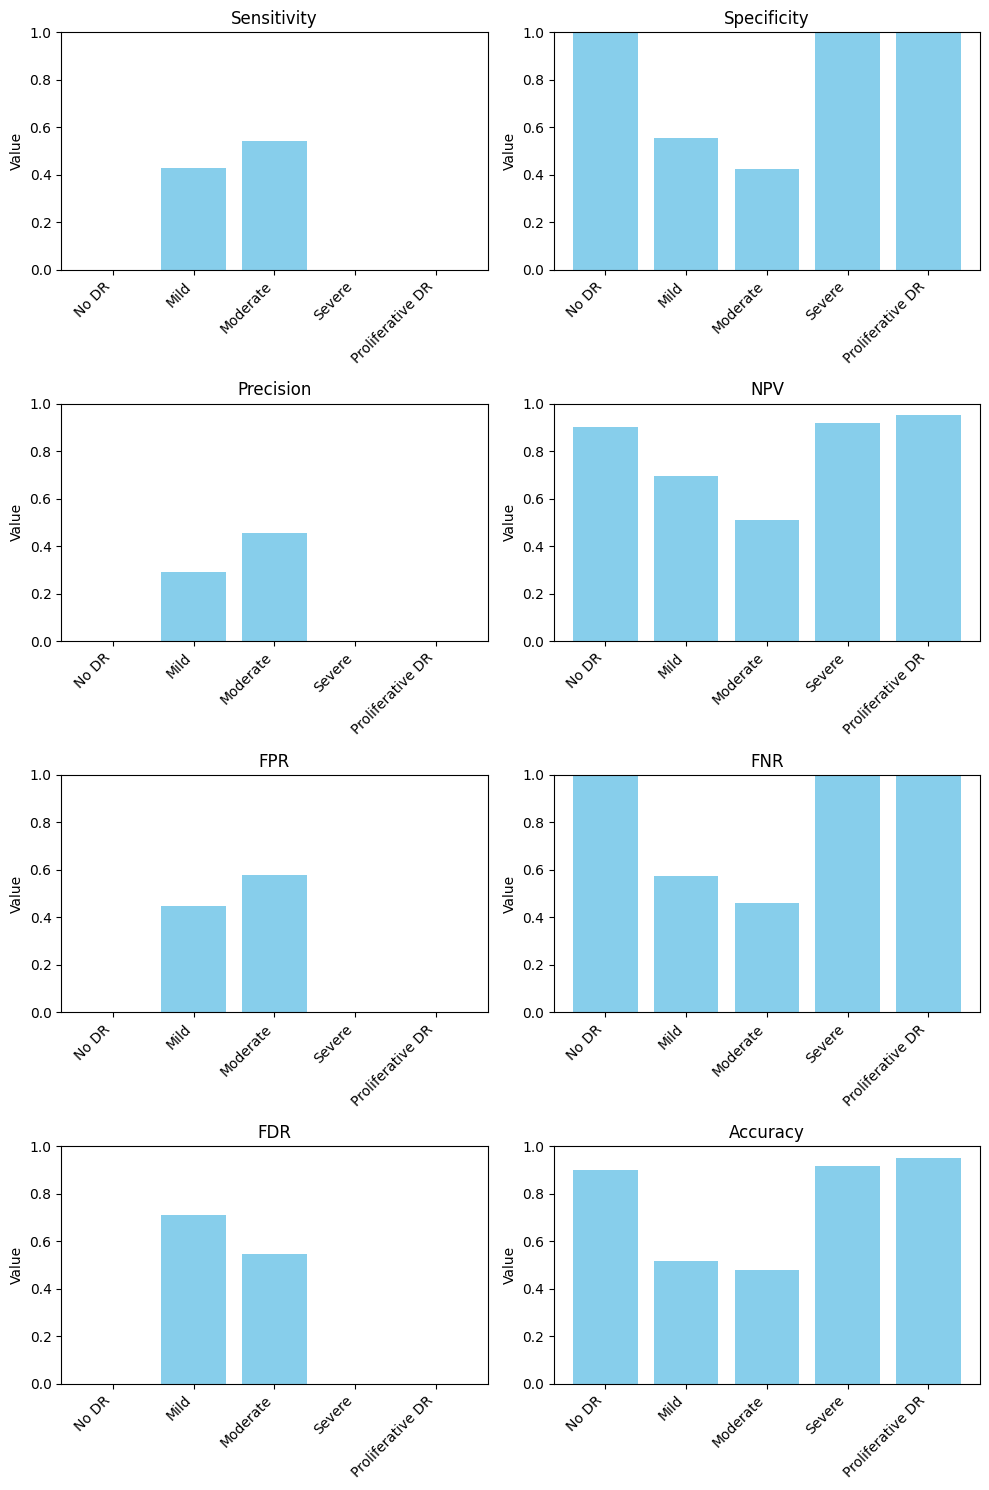

In [46]:
# Metrics to plot
metrics = [TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC]
metric_names = ['Sensitivity', 'Specificity', 'Precision', 'NPV', 'FPR', 'FNR', 'FDR', 'Accuracy']

# Plotting
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # Adjust the size as needed
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.bar(class_names, metrics[i], color='skyblue')
    ax.set_title(metric_names[i])
    ax.set_ylim(0, 1)  # Assuming metrics are between 0 and 1
    ax.set_ylabel('Value')
    ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()

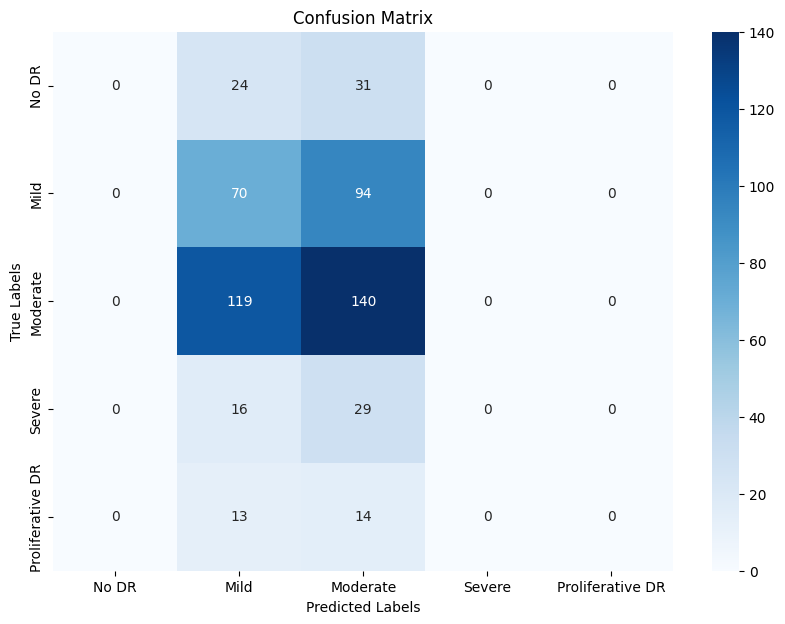

In [47]:
class_labels = class_names

plt.figure(figsize=(10, 7))

# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Evaluate on secondary DR Detection eyePACS test dataset

In [48]:
eyepacs_df = pd.read_csv('/content/drive/MyDrive/minitest.csv')
eyepacs_df.rename(columns={'image': 'Image', 'level': 'Labels'}, inplace=True)
eyepacs_df['Labels'].replace({0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative_DR'}, inplace=True)
eyepacs_df['Image'] = eyepacs_df['Image'] + '.jpeg'
eyepacs_df.head()

,Image,Labels
0,17123_right.jpeg,No_DR
1,12616_right.jpeg,No_DR
2,6541_left.jpeg,No_DR
3,14418_right.jpeg,No_DR
4,39598_left.jpeg,No_DR


In [49]:
# eyepacs generator

eyepacs_datagen = ImageDataGenerator(rescale = 1./255)

base_path = '/content/drive/My Drive/eyepacs'  # Your base path

eyepacs_generator = eyepacs_datagen.flow_from_dataframe(
    eyepacs_df,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 1001 validated image filenames belonging to 5 classes.


In [50]:
loss, accuracy, matthews_correlation_coefficient = model.evaluate(eyepacs_generator)
print('Test accuracy :', accuracy, 'Test MCC :', matthews_correlation_coefficient)

32/32 [==============================] - 283s 9s/step - loss: 1.0401 - accuracy: 1.0401 - matthews_correlation_coefficient: 0.0283
Test accuracy : 1.0401314496994019 Test MCC : 0.028272967785596848


In [51]:
# Predicting on the entire test set
predictions = model.predict(eyepacs_generator)

# Convert predictions from probability to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Assuming your test_generator.classes is already a 1D array of class labels
true_labels = eyepacs_generator.classes

# Generate the confusion matrix
epconf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(epconf_matrix)

# Generate and print classification report
report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(report)


32/32 [==============================] - 3s 93ms/step
Confusion Matrix:
[[  0   5  65   0   0]
 [  0   6 145   0   0]
 [  0  86 649   0   0]
 [  0   1  19   0   0]
 [  0   3  22   0   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.06      0.04      0.05       151
           2       0.72      0.88      0.79       735
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        25

    accuracy                           0.65      1001
   macro avg       0.16      0.18      0.17      1001
weighted avg       0.54      0.65      0.59      1001



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [52]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

FP = epconf_matrix.sum(axis=0) - np.diag(epconf_matrix)
FN = epconf_matrix.sum(axis=1) - np.diag(epconf_matrix)
TP = np.diag(epconf_matrix)
TN = epconf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)


# Calculate the metrics with conditions to handle division by zero
TPR = np.divide(TP, TP + FN, out=np.zeros_like(TP), where=(TP+FN)!=0)
TNR = np.divide(TN, TN + FP, out=np.zeros_like(TN), where=(TN+FP)!=0)
PPV = np.divide(TP, TP + FP, out=np.zeros_like(TP), where=(TP+FP)!=0)
NPV = np.divide(TN, TN + FN, out=np.zeros_like(TN), where=(TN+FN)!=0)
FPR = np.divide(FP, FP + TN, out=np.zeros_like(FP), where=(FP+TN)!=0)
FNR = np.divide(FN, TP + FN, out=np.zeros_like(FN), where=(TP+FN)!=0)
FDR = np.divide(FP, TP + FP, out=np.zeros_like(FP), where=(TP+FP)!=0)
ACC = np.divide(TP + TN, TP + FP + FN + TN, out=np.zeros_like(TP+TN), where=(TP+FP+FN+TN)!=0)

# Print metrics for each class
for i in range(len(class_names)):
    print(f"Class - {class_names[i]}")
    print(f"  Sensitivity: {TPR[i]}")
    print(f"  Specificity: {TNR[i]}")
    print(f"  Precision: {PPV[i]}")
    print(f"  Negative Predictive Value: {NPV[i]}")
    print(f"  False Positive Rate: {FPR[i]}")
    print(f"  False Negative Rate: {FNR[i]}")
    print(f"  False Discovery Rate: {FDR[i]}")
    print(f"  Overall Accuracy: {ACC[i]}\n")



Class - No DR
  Sensitivity: 0.0
  Specificity: 1.0
  Precision: 0.0
  Negative Predictive Value: 0.9300699300699301
  False Positive Rate: 0.0
  False Negative Rate: 1.0
  False Discovery Rate: 0.0
  Overall Accuracy: 0.9300699300699301

Class - Mild
  Sensitivity: 0.039735099337748346
  Specificity: 0.888235294117647
  Precision: 0.0594059405940594
  Negative Predictive Value: 0.8388888888888889
  False Positive Rate: 0.11176470588235295
  False Negative Rate: 0.9602649006622517
  False Discovery Rate: 0.9405940594059405
  Overall Accuracy: 0.7602397602397603

Class - Moderate
  Sensitivity: 0.8829931972789116
  Specificity: 0.05639097744360902
  Precision: 0.7211111111111111
  Negative Predictive Value: 0.1485148514851485
  False Positive Rate: 0.943609022556391
  False Negative Rate: 0.11700680272108843
  False Discovery Rate: 0.2788888888888889
  Overall Accuracy: 0.6633366633366633

Class - Severe
  Sensitivity: 0.0
  Specificity: 1.0
  Precision: 0.0
  Negative Predictive Value:

<ipython-input-53-86800b8bc2b8>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



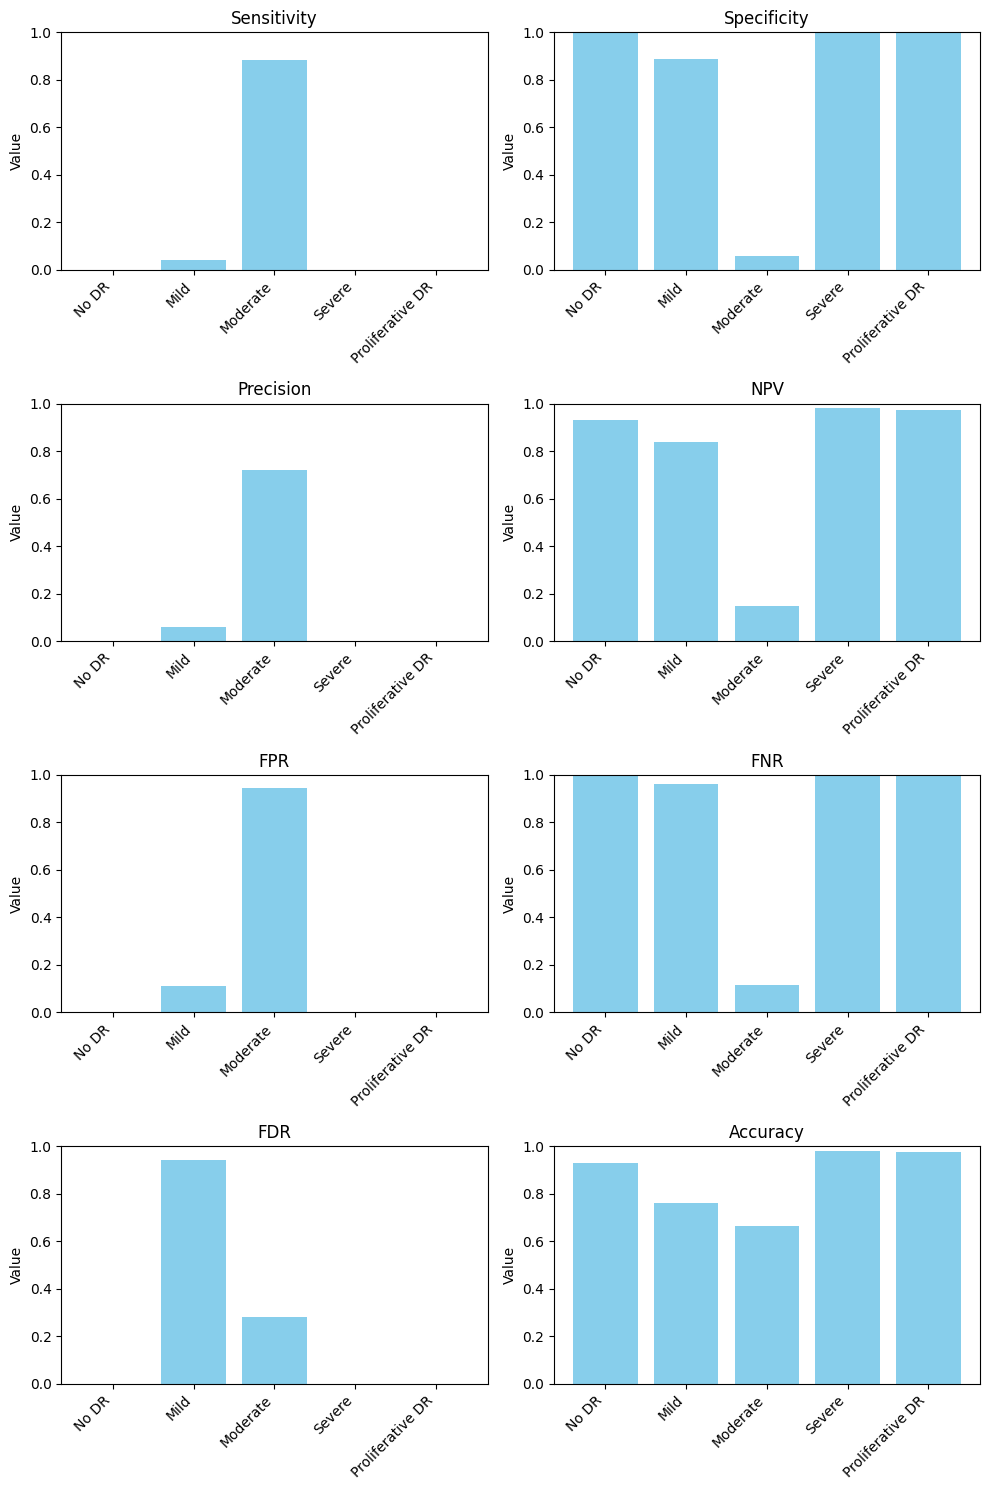

In [53]:
# Metrics to plot
metrics = [TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC]
metric_names = ['Sensitivity', 'Specificity', 'Precision', 'NPV', 'FPR', 'FNR', 'FDR', 'Accuracy']

# Plotting
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # Adjust the size as needed
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.bar(class_names, metrics[i], color='skyblue')
    ax.set_title(metric_names[i])
    ax.set_ylim(0, 1)  # Assuming metrics are between 0 and 1
    ax.set_ylabel('Value')
    ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()


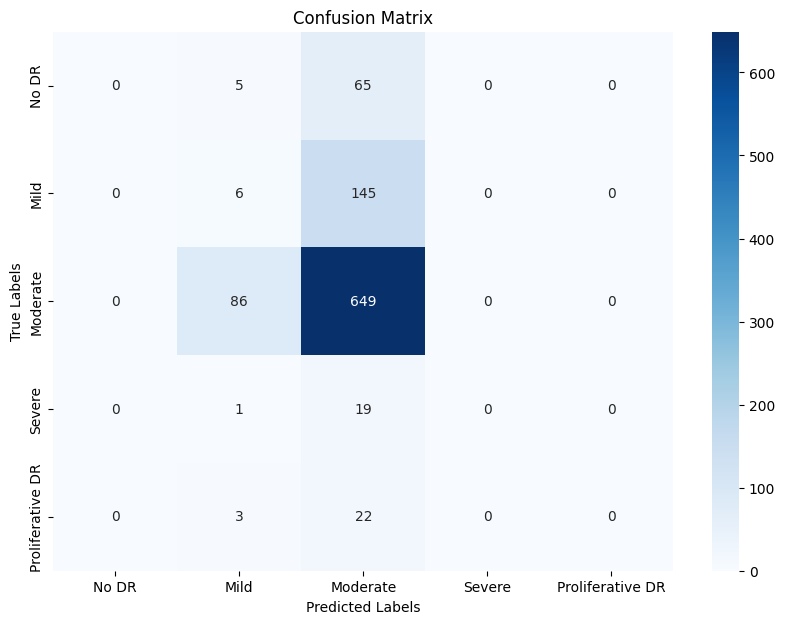

In [54]:
class_labels = class_names

plt.figure(figsize=(10, 7))

# Create a heatmap
sns.heatmap(epconf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()